In [1]:
import rasterio
from matplotlib import pyplot as plt
import numpy as np
from osgeo import gdal

/app/.venv/lib64/python3.11/site-packages/numpy/lib/scimath.py:46: RuntimeWarning: divide by zero encountered in log
  _ln2 = nx.log(2.0)


In [2]:
SRC = '/app/data/bees.tif'
RGBA = '/app/data/bees.rgba.tif'
DEST = '/app/data/bees.tif.cog'

In [3]:
src = rasterio.open(SRC)

src

<open DatasetReader name='/app/data/bees.tif' mode='r'>

In [26]:
src.profile

{'driver': 'GTiff', 'dtype': 'float64', 'nodata': -inf, 'width': 11950, 'height': 15500, 'count': 1, 'crs': CRS.from_epsg(32633), 'transform': Affine(100.0, 0.0, -75000.0,
       0.0, -100.0, 8000000.0), 'blockxsize': 512, 'blockysize': 512, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}

In [4]:
band = src.read(1, masked=True)
band_no_mask = src.read(1)

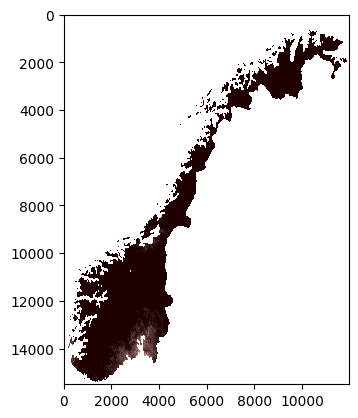

In [7]:
plt.imshow(band, cmap='pink')
plt.show()

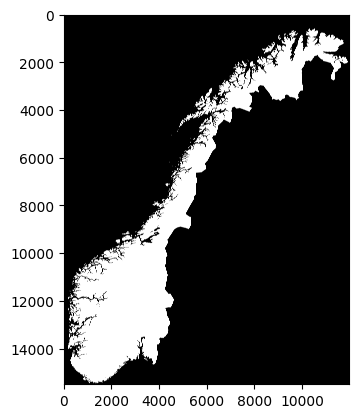

In [11]:
msk = src.read_masks(1)
plt.imshow(msk, cmap='gray')
plt.show()

In [5]:
band.max(), band.min()

(5564920367.662723, 0.0)

In [6]:
cmap = plt.get_cmap('viridis')

# Normalize grayscale values between 0 and 1
norm_grayscale_data = (band - band.min()) / (band.max() - band.min())

# Apply the colormap to get RGBA values
rgba_data = (cmap(norm_grayscale_data) * 255).astype(np.uint8)

# alpha_channel = np.where(band_no_mask == nodata_value, 0, 255)
# rgba_data[:, :, 3] = alpha_channel.astype(np.uint8)

In [26]:
np.shape(rgba_data), np.shape(src)

np.shape(np.rollaxis(rgba_data, 2))

(4, 15500, 11950)

In [30]:
# Create an output raster with RGBA values
profile = src.profile.copy()
profile.update(dtype=rasterio.uint8, count=4, nodata=None, photometric='RGBA')
profile

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 11950, 'height': 15500, 'count': 4, 'crs': CRS.from_epsg(32633), 'transform': Affine(100.0, 0.0, -75000.0,
       0.0, -100.0, 8000000.0), 'blockxsize': 512, 'blockysize': 512, 'tiled': True, 'compress': 'lzw', 'interleave': 'band', 'photometric': 'RGBA'}

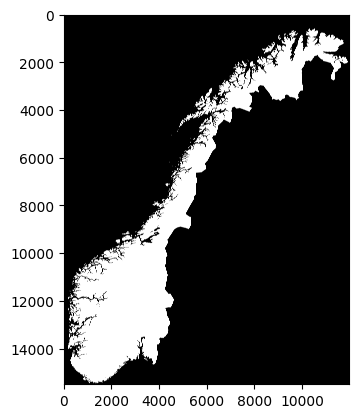

In [17]:
plt.imshow(rgba_data[:, :, 3], cmap='gray')
plt.show()

In [27]:
with rasterio.open(RGBA, 'w+', **profile) as dst:
        dst.write(np.rollaxis(rgba_data, 2))

In [33]:
src_ds = gdal.Open(RGBA)

# Create options for the COG transformation
options = [
    'COMPRESS=DEFLATE',
    'TILING_SCHEME=GoogleMapsCompatible',
    'ADD_ALPHA=NO',
]

# Translate and create the COG
gdal.Translate(DEST, src_ds, format='COG', creationOptions=options)


<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7f9efa78a610> >